# quant-econ Solutions: Infinite Horizon Dynamic Programming

Solutions for http://quant-econ.net/py/optgrowth.html

Our objective is to compute the policy functions in the figures from the lecture URL give above.

In [2]:
%matplotlib inline

First let's add a few imports

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import quantecon as qe

Now, we could import the functionality we need from `optgrowth_v0.py` or we could load that file here. A good software engineer would probably tell us to go for the first option, so as to avoid having the same code in two places. But sometimes it helps to break the rules.  We want to break the rules here because it's nice to have the code all together in one place. So here's an excert from that file:

In [4]:
from numpy import log
from scipy.optimize import fminbound
from scipy import interp

# Primitives and grid
alpha = 0.65
beta = 0.95
grid_max = 2
grid_size = 150
grid = np.linspace(1e-6, grid_max, grid_size)
# Exact solution
ab = alpha * beta
c1 = (log(1 - ab) + log(ab) * ab / (1 - ab)) / (1 - beta)
c2 = alpha / (1 - ab)


def v_star(k):
    return c1 + c2 * log(k)


def bellman_operator(w):
    """
    The approximate Bellman operator, which computes and returns the updated
    value function Tw on the grid points.

        * w is a flat NumPy array with len(w) = len(grid)

    The vector w represents the value of the input function on the grid
    points.
    """
    # === Apply linear interpolation to w === #
    Aw = lambda x: interp(x, grid, w)

    # === set Tw[i] equal to max_c { log(c) + beta w(f(k_i) - c)} === #
    Tw = np.empty(grid_size)
    for i, k in enumerate(grid):
        objective = lambda c: - log(c) - beta * Aw(k**alpha - c)
        c_star = fminbound(objective, 1e-6, k**alpha)
        Tw[i] = - objective(c_star)
    return Tw

Now we need a function to get the greedy policy from an approximate value function.

In [5]:
def compute_greedy(w):
    Aw = lambda x: interp(x, grid, w) 

    sigma = np.empty(grid_size)
    for i, k in enumerate(grid):
        objective = lambda c: - log(c) - beta * Aw(k**alpha - c)
        sigma[i] = fminbound(objective, 1e-6, k**alpha)
    return sigma
    

## Exercise 1

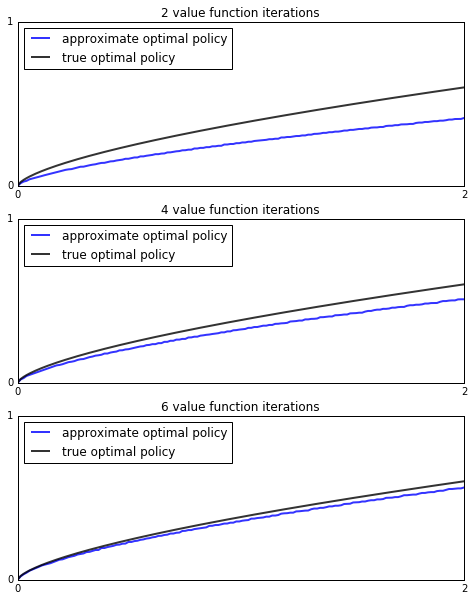

In [6]:
alpha, beta = 0.65, 0.95
true_sigma = (1 - alpha * beta) * grid**alpha

fig, ax = plt.subplots(3, 1, figsize=(8, 10))

for i, n in enumerate((2, 4, 6)):
    ax[i].set_ylim(0, 1)
    ax[i].set_xlim(0, 2)
    ax[i].set_yticks((0, 1))
    ax[i].set_xticks((0, 2))

    w = 5 * log(grid) - 25  # Initial condition
    v_star = qe.compute_fixed_point(bellman_operator, w, 
                                 max_iter=n, 
                                 verbose=0)
    sigma = compute_greedy(v_star)

    ax[i].plot(grid, sigma, 'b-', lw=2, alpha=0.8, label='approximate optimal policy')
    ax[i].plot(grid, true_sigma, 'k-', lw=2, alpha=0.8, label='true optimal policy')
    ax[i].legend(loc='upper left')
    ax[i].set_title('{} value function iterations'.format(n))
    


## Exercise 2

For this exercise we need to compute the optimal policy at a number of different parameter values.  This is quite awkward to do given the way the code is written above.  (One of the purposes of the present exercise is to highlight this fact.) In [a follow up lecture](http://quant-econ.net/py/optgrowth_2.html) we'll try to write code that can manage operating over different parameters in a nice way, using functions and classes.  Here we'll just copy and paste from above.  Note, however, that copying and pasting is almost always the worst solution (including this case too).  The reason is that it violates the basic principle [do not repeat yourself](https://en.wikipedia.org/wiki/Don't_repeat_yourself).

Bearing the above in mind, for now our (second best) strategy will be to copy the code for the Bellman operator and add in `beta` as an argument to the function.

In [7]:
def bellman_operator(w, beta=0.96):

    # === Apply linear interpolation to w === #
    Aw = lambda x: interp(x, grid, w)

    # === set Tw[i] equal to max_c { log(c) + beta w(f(k_i) - c)} === #
    Tw = np.empty(grid_size)
    for i, k in enumerate(grid):
        objective = lambda c: - log(c) - beta * Aw(k**alpha - c)
        c_star = fminbound(objective, 1e-6, k**alpha)
        Tw[i] = - objective(c_star)
    return Tw

Let's also do the same for `compute_greedy`

In [8]:
def compute_greedy(w, beta=0.96):
    Aw = lambda x: interp(x, grid, w) 

    sigma = np.empty(grid_size)
    for i, k in enumerate(grid):
        objective = lambda c: - log(c) - beta * Aw(k**alpha - c)
        sigma[i] = fminbound(objective, 1e-6, k**alpha)
    return sigma

Now let's compute the policies and the figures

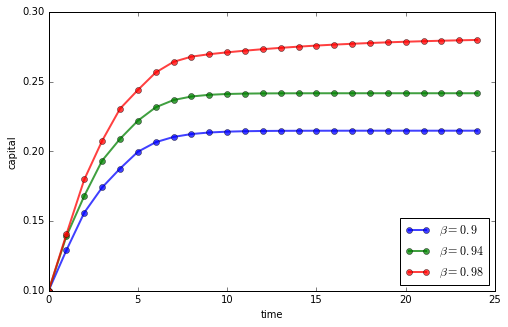

In [9]:
w = 5 * np.log(grid) - 25  # To be used as an initial condition
discount_factors = (0.9, 0.94, 0.98)
series_length = 25

fig, ax = plt.subplots(figsize=(8,5))
ax.set_xlabel("time")
ax.set_ylabel("capital")
ax.set_ylim(0.10, 0.30)

for beta in discount_factors:
    
    w = 5 * log(grid) - 25  # Initial condition
    v_star = qe.compute_fixed_point(bellman_operator, 
                                    w, 
                                    verbose=False,
                                    beta=beta)
                        
    sigma = compute_greedy(v_star, beta)
    
    # Compute the corresponding time series for capital
    k = np.empty(series_length)
    k[0] = 0.1
    sigma_function = lambda x: interp(x, grid, sigma)
    for t in range(1, series_length):
        k[t] = k[t-1]**alpha - sigma_function(k[t-1])
    ax.plot(k, 'o-', lw=2, alpha=0.75, label=r'$\beta = {}$'.format(beta))

ax.legend(loc='lower right')
plt.show()